# Time Series Analysis and Forecasting📈 on Australia Tourism🌅


In this notebook:
* Dataset Exploration
* Data Preprocessing
* Time-Series Analysis
* Time Series Forecasting with ARIMA
* Time Series Forecasting with Prophet
* LSTM out-of-sample prediction
* LSTM one-step-ahead forecast for future

In [1]:
# import packages
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
#read data
data = pd.read_csv('../input/au-tourism/tourism.csv')
data

,Unnamed: 0,Quarter,Region,State,Purpose,Trips
0,1,1998 Q1,Adelaide,South Australia,Business,135.077690
1,2,1998 Q2,Adelaide,South Australia,Business,109.987316
2,3,1998 Q3,Adelaide,South Australia,Business,166.034687
3,4,1998 Q4,Adelaide,South Australia,Business,127.160464
4,5,1999 Q1,Adelaide,South Australia,Business,137.448533
...,...,...,...,...,...,...
24315,24316,2016 Q4,Yorke Peninsula,South Australia,Visiting,33.672151
24316,24317,2017 Q1,Yorke Peninsula,South Australia,Visiting,46.223014
24317,24318,2017 Q2,Yorke Peninsula,South Australia,Visiting,50.582837
24318,24319,2017 Q3,Yorke Peninsula,South Australia,Visiting,27.766728


In [3]:
data=data.drop(columns="Unnamed: 0")
data

,Quarter,Region,State,Purpose,Trips
0,1998 Q1,Adelaide,South Australia,Business,135.077690
1,1998 Q2,Adelaide,South Australia,Business,109.987316
2,1998 Q3,Adelaide,South Australia,Business,166.034687
3,1998 Q4,Adelaide,South Australia,Business,127.160464
4,1999 Q1,Adelaide,South Australia,Business,137.448533
...,...,...,...,...,...
24315,2016 Q4,Yorke Peninsula,South Australia,Visiting,33.672151
24316,2017 Q1,Yorke Peninsula,South Australia,Visiting,46.223014
24317,2017 Q2,Yorke Peninsula,South Australia,Visiting,50.582837
24318,2017 Q3,Yorke Peninsula,South Australia,Visiting,27.766728


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24320 entries, 0 to 24319
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  24320 non-null  object 
 1   Region   24320 non-null  object 
 2   State    24320 non-null  object 
 3   Purpose  24320 non-null  object 
 4   Trips    24320 non-null  float64
dtypes: float64(1), object(4)
memory usage: 950.1+ KB


In [5]:
data.nunique()

Quarter       80
Region        76
State          8
Purpose        4
Trips      22702
dtype: int64

In [6]:
data.describe()

,Trips
count,24320.000000
mean,70.896448
std,118.763185
min,0.000000
25%,7.223910
50%,28.134538
75%,78.154410
max,985.278401


# EDA

In [7]:
sorted(data['Quarter'].value_counts().index)

['1998 Q1',
 '1998 Q2',
 '1998 Q3',
 '1998 Q4',
 '1999 Q1',
 '1999 Q2',
 '1999 Q3',
 '1999 Q4',
 '2000 Q1',
 '2000 Q2',
 '2000 Q3',
 '2000 Q4',
 '2001 Q1',
 '2001 Q2',
 '2001 Q3',
 '2001 Q4',
 '2002 Q1',
 '2002 Q2',
 '2002 Q3',
 '2002 Q4',
 '2003 Q1',
 '2003 Q2',
 '2003 Q3',
 '2003 Q4',
 '2004 Q1',
 '2004 Q2',
 '2004 Q3',
 '2004 Q4',
 '2005 Q1',
 '2005 Q2',
 '2005 Q3',
 '2005 Q4',
 '2006 Q1',
 '2006 Q2',
 '2006 Q3',
 '2006 Q4',
 '2007 Q1',
 '2007 Q2',
 '2007 Q3',
 '2007 Q4',
 '2008 Q1',
 '2008 Q2',
 '2008 Q3',
 '2008 Q4',
 '2009 Q1',
 '2009 Q2',
 '2009 Q3',
 '2009 Q4',
 '2010 Q1',
 '2010 Q2',
 '2010 Q3',
 '2010 Q4',
 '2011 Q1',
 '2011 Q2',
 '2011 Q3',
 '2011 Q4',
 '2012 Q1',
 '2012 Q2',
 '2012 Q3',
 '2012 Q4',
 '2013 Q1',
 '2013 Q2',
 '2013 Q3',
 '2013 Q4',
 '2014 Q1',
 '2014 Q2',
 '2014 Q3',
 '2014 Q4',
 '2015 Q1',
 '2015 Q2',
 '2015 Q3',
 '2015 Q4',
 '2016 Q1',
 '2016 Q2',
 '2016 Q3',
 '2016 Q4',
 '2017 Q1',
 '2017 Q2',
 '2017 Q3',
 '2017 Q4']

In [8]:
data['State'].value_counts()

Victoria              6720
New South Wales       4160
Queensland            3840
South Australia       3840
Northern Territory    2240
Tasmania              1600
Western Australia     1600
ACT                    320
Name: State, dtype: int64

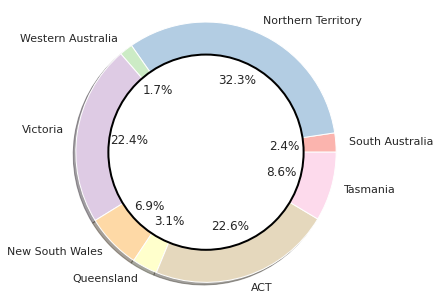

In [9]:
import matplotlib.pyplot as plt
from palettable.colorbrewer.qualitative import Pastel1_8

dw=data.groupby('State')["Trips"].sum().reset_index()

#create data
names=list(data["State"].unique())
total_trips=dw["Trips"].sum()

dw["Trips-%"]=dw["Trips"] / total_trips

sns.set(style = 'white', font_scale = 1)
colors = Pastel1_8.hex_colors
explode = (0, 0, 0, 0, 0, 0, 0, 0)  # explode a slice if required

plt.figure(figsize=(5,5))
plt.pie(dw["Trips-%"], explode=explode, labels=names, colors=colors,
        autopct='%1.1f%%', shadow=True)
        
#draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=2)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

#set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

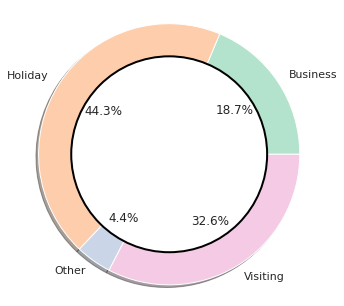

In [10]:
import matplotlib.pyplot as plt
from palettable.colorbrewer.qualitative import Pastel2_5

dp=data.groupby('Purpose')["Trips"].sum().reset_index()

#create data
names=list(data["Purpose"].unique())
total_trips=dw["Trips"].sum()

dp["Trips-%"]=dp["Trips"] / total_trips

sns.set(style = 'white', font_scale = 1)
colors = Pastel2_5.hex_colors
explode = (0, 0, 0, 0)  # explode a slice if required

plt.figure(figsize=(5,5))
plt.pie(dp["Trips-%"], explode=explode, labels=names, colors=colors,
        autopct='%1.1f%%', shadow=True)
        
#draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.75, color='black', fc='white',linewidth=2)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

#set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

In [11]:
#most visited 10 regions
df_region=data.groupby('Region')["Trips"].sum().reset_index().sort_values("Trips", ascending=False)
df_region.reset_index(drop=True, inplace=True)
top_10_region=df_region.loc[:9, :]
top_10_region


#least visited 10 regions
bottom_10_region=df_region.tail(10)
bottom_10_region

,Region,Trips
66,Kakadu Arnhem,3814.742876
67,Wilderness West,3203.226937
68,Clare Valley,3111.734453
69,Lasseter,2817.453420
70,Murray East,2565.753258
71,Wimmera,2489.617947
72,Adelaide Hills,2299.117803
73,Kangaroo Island,1841.953784
74,Barkly,1388.317029
75,MacDonnell,1190.979697


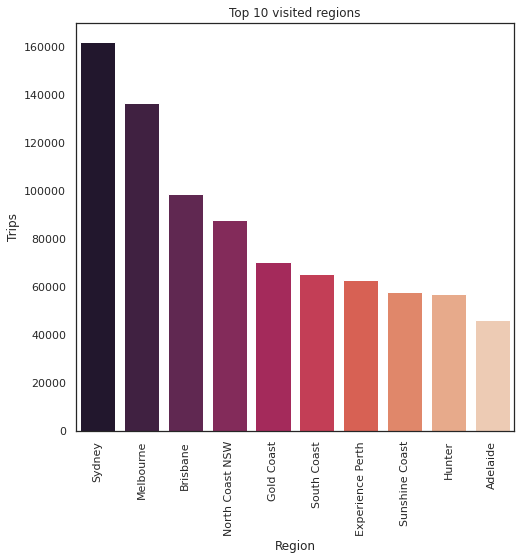

In [12]:
plt.figure(figsize=(7,7))
sns.barplot(x="Region", y="Trips", data=top_10_region, palette="rocket")
plt.title("Top 10 visited regions")
plt.xticks(rotation=90);

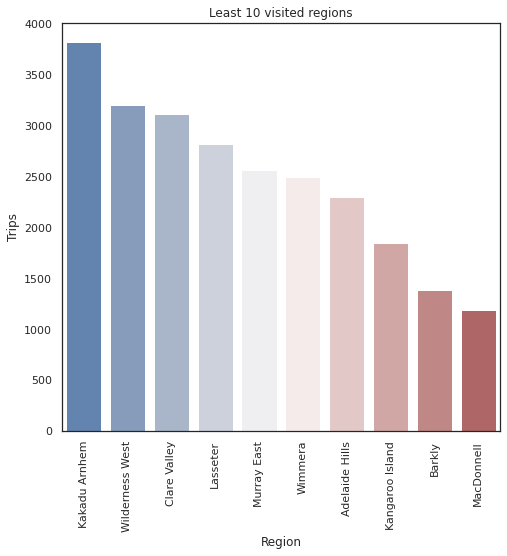

In [13]:
plt.figure(figsize=(7,7))
sns.barplot(x="Region", y="Trips", data=bottom_10_region, palette="vlag")
plt.title("Least 10 visited regions")
plt.xticks(rotation=90);

We need "Quarter" feature in "datetime type"  while making forecast, below convert object type to datetime type and 
rename column as a "date".

In [14]:
date=pd.to_datetime(data['Quarter'].str.replace(' ', '')) + pd.offsets.QuarterEnd(0)
df_date=date.to_frame()
df_date=df_date.rename(columns={"Quarter": "date"})

In [15]:
df=pd.concat([df_date, data], axis=1)

In [16]:
df[['year','q']] = df['Quarter'].str.split('Q', expand=True)
df['year'] = df['year'].astype(int)
df['q'] = 'Q' + df['q']

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24320 entries, 0 to 24319
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     24320 non-null  datetime64[ns]
 1   Quarter  24320 non-null  object        
 2   Region   24320 non-null  object        
 3   State    24320 non-null  object        
 4   Purpose  24320 non-null  object        
 5   Trips    24320 non-null  float64       
 6   year     24320 non-null  int64         
 7   q        24320 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 1.5+ MB


In [18]:
df

,date,Quarter,Region,State,Purpose,Trips,year,q
0,1998-03-31,1998 Q1,Adelaide,South Australia,Business,135.077690,1998,Q1
1,1998-06-30,1998 Q2,Adelaide,South Australia,Business,109.987316,1998,Q2
2,1998-09-30,1998 Q3,Adelaide,South Australia,Business,166.034687,1998,Q3
3,1998-12-31,1998 Q4,Adelaide,South Australia,Business,127.160464,1998,Q4
4,1999-03-31,1999 Q1,Adelaide,South Australia,Business,137.448533,1999,Q1
...,...,...,...,...,...,...,...,...
24315,2016-12-31,2016 Q4,Yorke Peninsula,South Australia,Visiting,33.672151,2016,Q4
24316,2017-03-31,2017 Q1,Yorke Peninsula,South Australia,Visiting,46.223014,2017,Q1
24317,2017-06-30,2017 Q2,Yorke Peninsula,South Australia,Visiting,50.582837,2017,Q2
24318,2017-09-30,2017 Q3,Yorke Peninsula,South Australia,Visiting,27.766728,2017,Q3


In [19]:
df = df[['date', 'Quarter', 'year', 'q', 'State', 'Region', 'Purpose', 'Trips']]
df=df.drop(columns=["Quarter", "q"])
df

,date,year,State,Region,Purpose,Trips
0,1998-03-31,1998,South Australia,Adelaide,Business,135.077690
1,1998-06-30,1998,South Australia,Adelaide,Business,109.987316
2,1998-09-30,1998,South Australia,Adelaide,Business,166.034687
3,1998-12-31,1998,South Australia,Adelaide,Business,127.160464
4,1999-03-31,1999,South Australia,Adelaide,Business,137.448533
...,...,...,...,...,...,...
24315,2016-12-31,2016,South Australia,Yorke Peninsula,Visiting,33.672151
24316,2017-03-31,2017,South Australia,Yorke Peninsula,Visiting,46.223014
24317,2017-06-30,2017,South Australia,Yorke Peninsula,Visiting,50.582837
24318,2017-09-30,2017,South Australia,Yorke Peninsula,Visiting,27.766728


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24320 entries, 0 to 24319
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     24320 non-null  datetime64[ns]
 1   year     24320 non-null  int64         
 2   State    24320 non-null  object        
 3   Region   24320 non-null  object        
 4   Purpose  24320 non-null  object        
 5   Trips    24320 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 1.1+ MB


In [21]:
state_trips = df.groupby(['State'])['Trips'].sum()
df_state_trips=pd.DataFrame(state_trips)
df_state_trips

,Trips
State,
ACT,41006.585207
New South Wales,557367.430368
Northern Territory,28613.683011
Queensland,386642.911752
South Australia,118151.348155
Tasmania,54137.094786
Victoria,390462.911453
Western Australia,147819.653238


In [22]:
state_year_trips = df.groupby(['State', 'year'])['Trips'].sum()
df_state_year_trips=pd.DataFrame(state_year_trips)
dd=df_state_year_trips.reset_index()

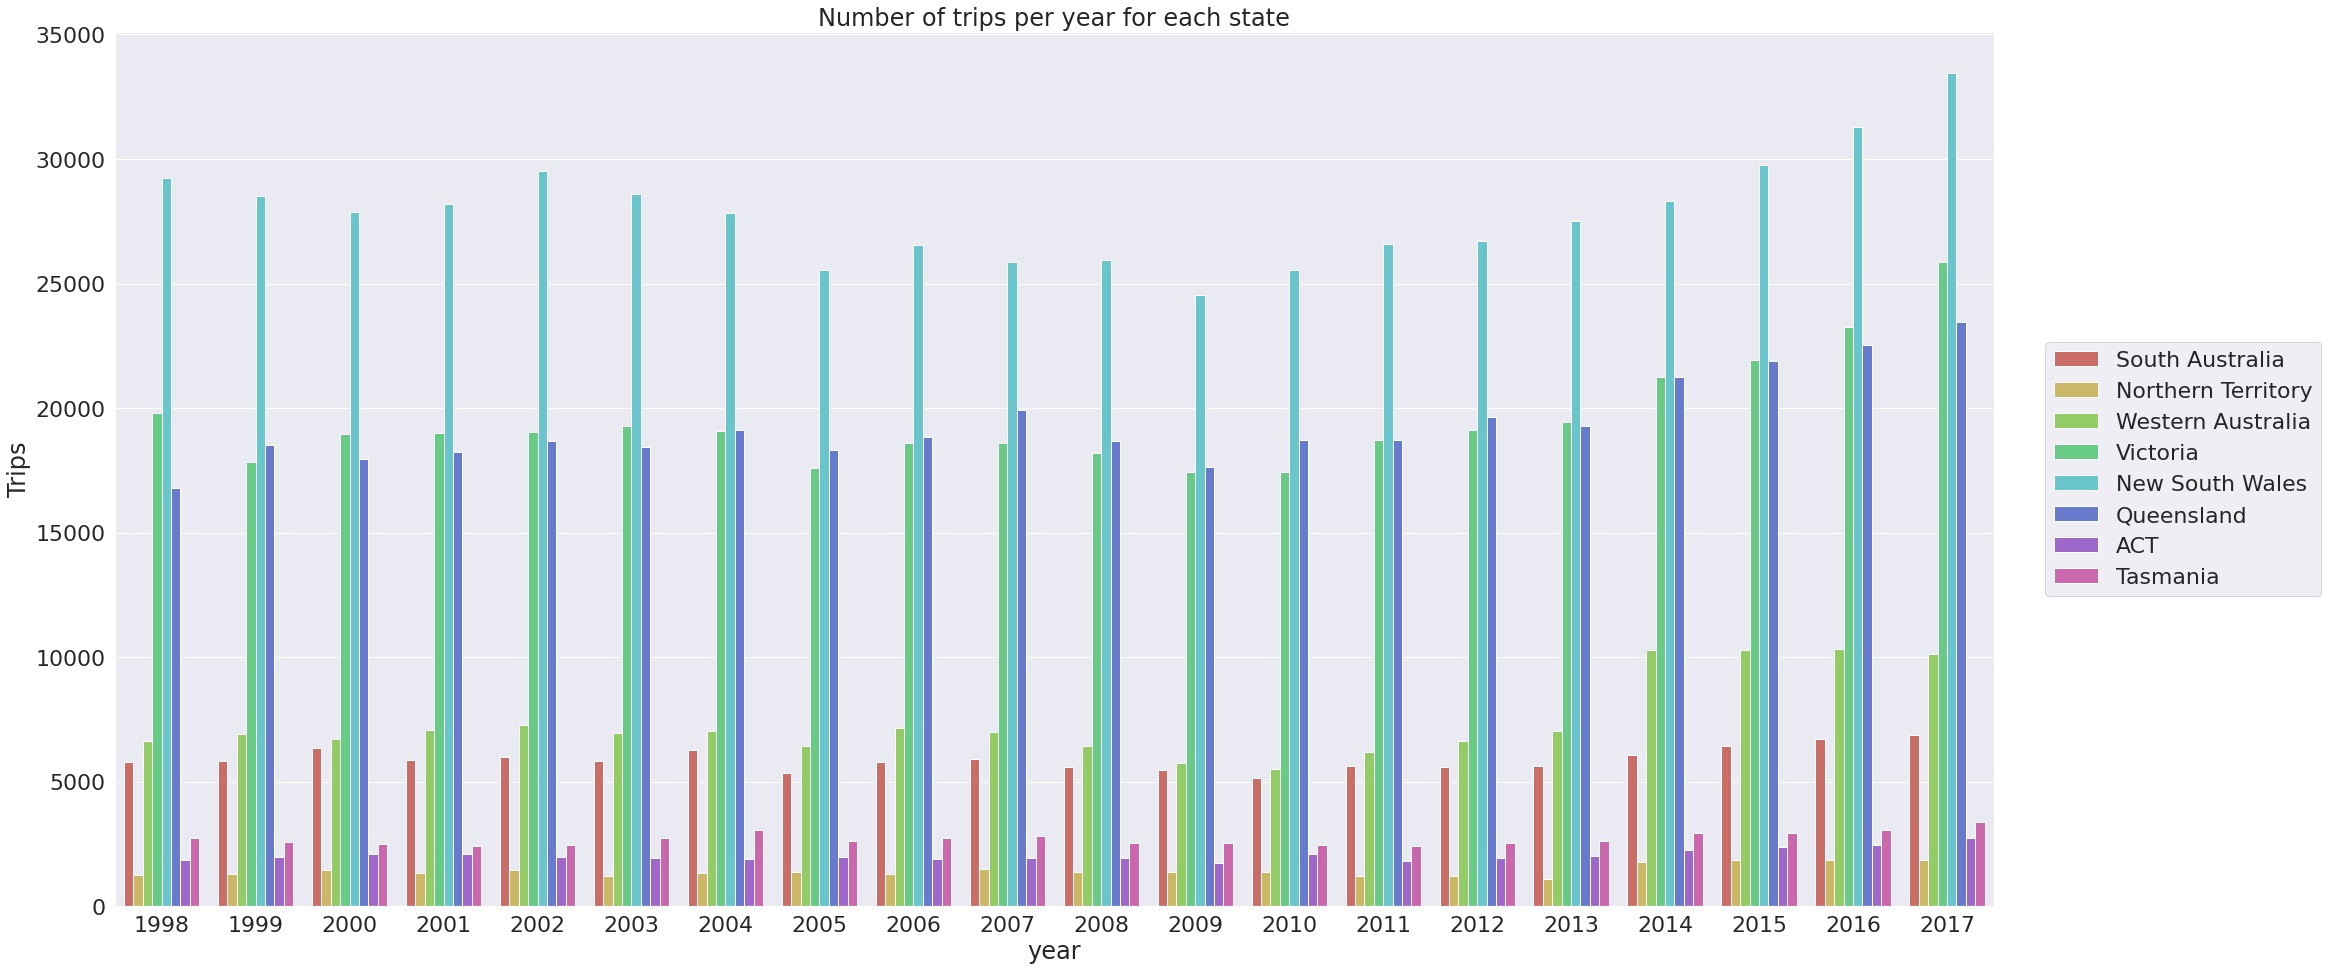

In [23]:
state_names=list(df['State'].unique())

#parameters
plt.rcParams['figure.figsize'] = [30, 15]
sns.set(style = 'white', font_scale = 2)
sns.set_style("darkgrid")

#plot
arrival = sns.barplot(x='year', y="Trips", hue = 'State', data = dd, palette = sns.color_palette("hls", 8), hue_order = state_names)

arrival.set(title = "Number of trips per year for each state")
plt.legend(loc='right', bbox_to_anchor=(1.18, 0.5));

In [24]:
state_purpose_trips = df.groupby(['State', 'Purpose'])['Trips'].sum()
df_state_purpose_trips=pd.DataFrame(state_purpose_trips)
ds=df_state_purpose_trips.reset_index()

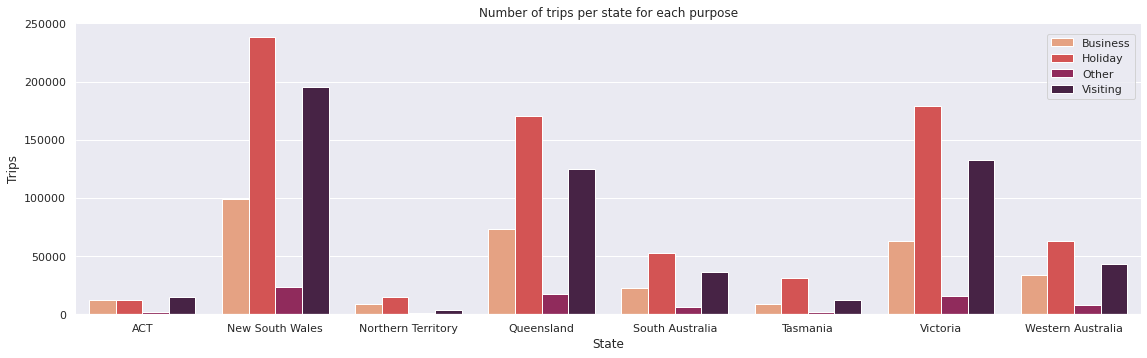

In [25]:
# parameters
plt.rcParams['figure.figsize'] = [17, 5]
sns.set(style = 'white', font_scale = 1)
sns.set_style("darkgrid")

# plot
arr = sns.barplot(x='State', y="Trips", hue = 'Purpose', data = ds, palette = sns.color_palette("rocket_r", 4))

arr.set(title = "Number of trips per state for each purpose")
sns.despine(left=True);
plt.legend(loc='right', bbox_to_anchor=(1, 0.85));

In [26]:
df.head()

,date,year,State,Region,Purpose,Trips
0,1998-03-31,1998,South Australia,Adelaide,Business,135.077690
1,1998-06-30,1998,South Australia,Adelaide,Business,109.987316
2,1998-09-30,1998,South Australia,Adelaide,Business,166.034687
3,1998-12-31,1998,South Australia,Adelaide,Business,127.160464
4,1999-03-31,1999,South Australia,Adelaide,Business,137.448533


# Time Series Analysis

In [27]:
state_sa = df.loc[df['State'] == 'South Australia']
state_nsw = df.loc[df['State'] == 'New South Wales']
state_vic = df.loc[df['State'] == 'Victoria']

#state_sa['date'].min(), state_sa['date'].max()
#state_nsw['date'].min(), state_nsw['date'].max()
state_vic['date'].min(), state_vic['date'].max()

(Timestamp('1998-03-31 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [28]:
cols=["year", "Region", "Purpose"]
state_sa.drop(cols, axis=1, inplace=True)
state_sa = state_sa.sort_values('date')

print("South Australia:\n", state_sa.isnull().sum())

###########    ###########   ###########

state_nsw.drop(cols, axis=1, inplace=True)
state_nsw = state_nsw.sort_values('date')

print("New South Wales:\n", state_nsw.isnull().sum())

###########    ###########   ###########

state_vic.drop(cols, axis=1, inplace=True)
state_vic = state_vic.sort_values('date')

print("Victoria:\n", state_vic.isnull().sum())

South Australia:
 date     0
State    0
Trips    0
dtype: int64
New South Wales:
 date     0
State    0
Trips    0
dtype: int64
Victoria:
 date     0
State    0
Trips    0
dtype: int64


In [29]:
state_sa = state_sa.groupby('date')['Trips'].sum().reset_index()
state_sa = state_sa.set_index('date')
state_sa.index

###########    ###########   ###########
state_nsw = state_nsw.groupby('date')['Trips'].sum().reset_index()
state_nsw = state_nsw.set_index('date')
state_nsw.index

###########    ###########   ###########
state_vic = state_vic.groupby('date')['Trips'].sum().reset_index()
state_vic = state_vic.set_index('date')
state_vic.index

DatetimeIndex(['1998-03-31', '1998-06-30', '1998-09-30', '1998-12-31',
               '1999-03-31', '1999-06-30', '1999-09-30', '1999-12-31',
               '2000-03-31', '2000-06-30', '2000-09-30', '2000-12-31',
               '2001-03-31', '2001-06-30', '2001-09-30', '2001-12-31',
               '2002-03-31', '2002-06-30', '2002-09-30', '2002-12-31',
               '2003-03-31', '2003-06-30', '2003-09-30', '2003-12-31',
               '2004-03-31', '2004-06-30', '2004-09-30', '2004-12-31',
               '2005-03-31', '2005-06-30', '2005-09-30', '2005-12-31',
               '2006-03-31', '2006-06-30', '2006-09-30', '2006-12-31',
               '2007-03-31', '2007-06-30', '2007-09-30', '2007-12-31',
               '2008-03-31', '2008-06-30', '2008-09-30', '2008-12-31',
               '2009-03-31', '2009-06-30', '2009-09-30', '2009-12-31',
               '2010-03-31', '2010-06-30', '2010-09-30', '2010-12-31',
               '2011-03-31', '2011-06-30', '2011-09-30', '2011-12-31',
      

Our current datetime data can be tricky to work with, but not(dataset only consists end of the each four quarters).
Make it guarantee we will be using the end of each quarter as the timestamp.

In [30]:
south_au = state_sa['Trips'].resample('Q').mean()
df_state_sa=south_au.reset_index()

###########    ###########   ###########
nsw = state_nsw['Trips'].resample('Q').mean()
df_state_nsw=nsw.reset_index()

###########    ###########   ###########
vic = state_vic['Trips'].resample('Q').mean()
df_state_vic=vic.reset_index()

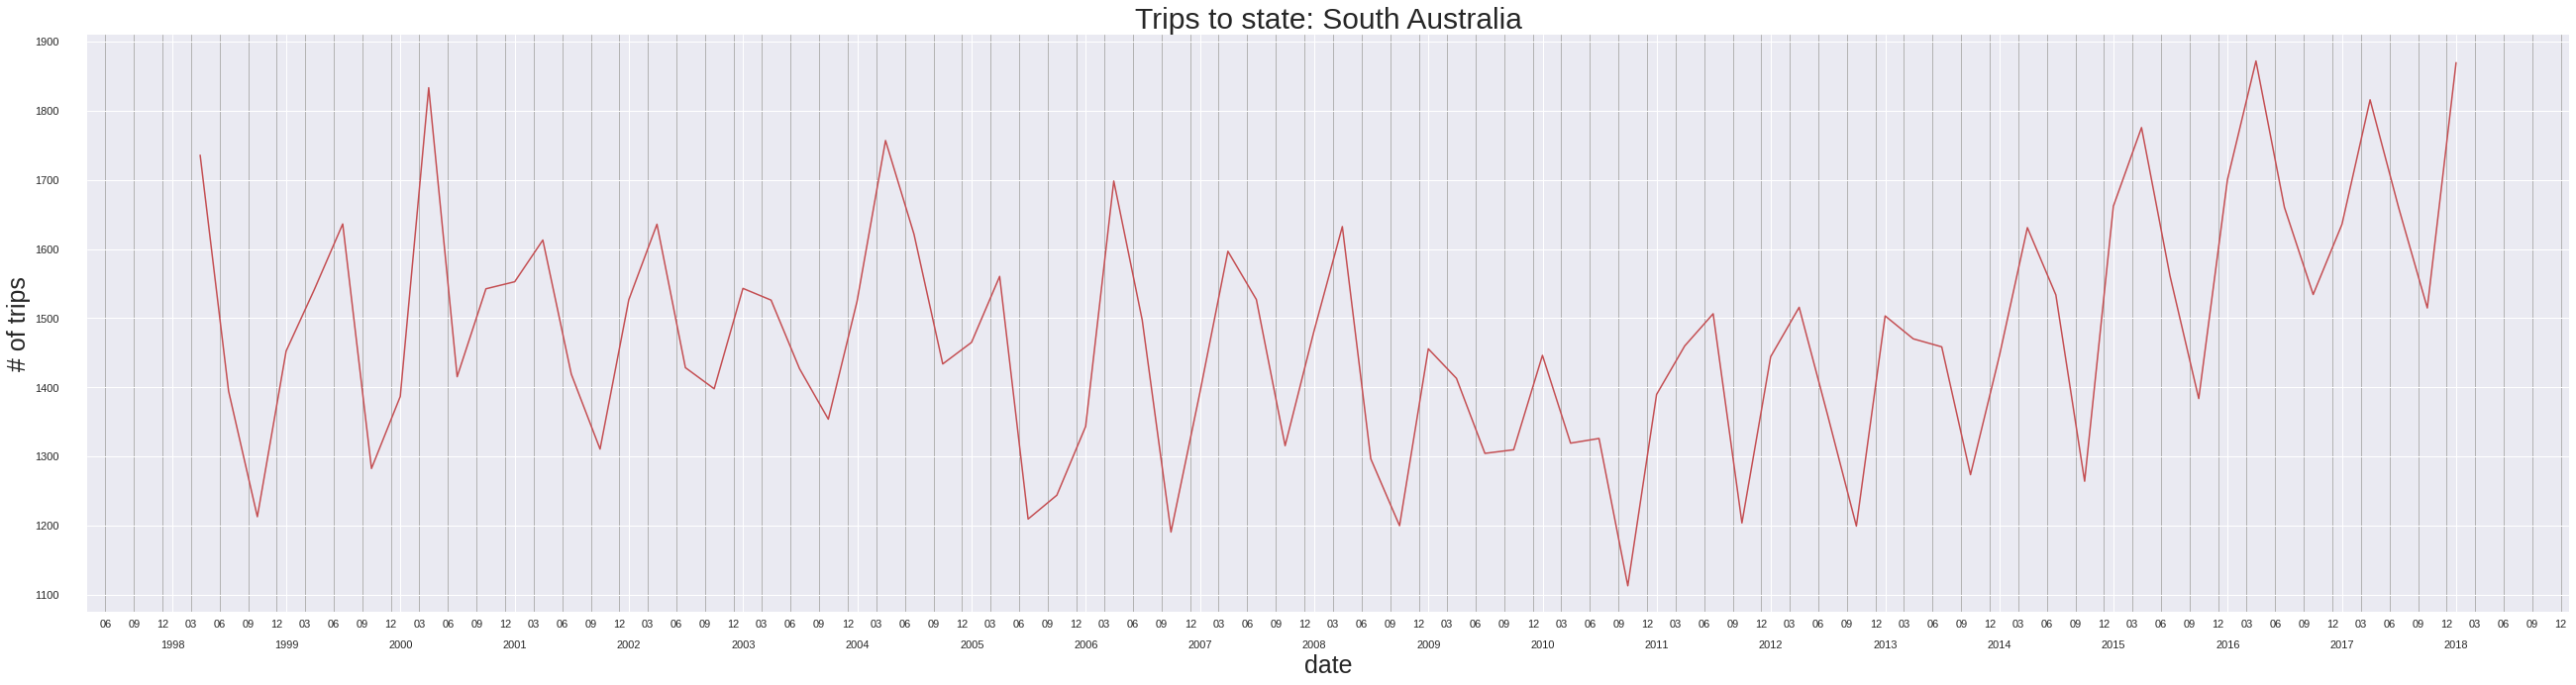

In [31]:
###### South Australia ######
plt.style.use("seaborn-darkgrid")

plt.figure(figsize=(40, 10))
plt.title("Trips to state: South Australia", fontsize=30)
plt.xlabel("date", fontsize=25)
plt.ylabel("# of trips", fontsize=25)

ax = plt.gca()

yearformatter = mdates.DateFormatter("%Y")
monthformatter = mdates.DateFormatter("%m")

yearlocator = mdates.YearLocator()
ax.xaxis.set_major_locator(yearlocator)

monthlocator = mdates.MonthLocator((3,6,9,12))
ax.xaxis.set_minor_locator(monthlocator)

ax.xaxis.set_major_formatter(yearformatter)
ax.xaxis.set_minor_formatter(monthformatter)

ax.tick_params(which='major', length=25)
ax.tick_params(which='minor',length=4 )

plt.grid(b=True, which='minor', color='0.7', linestyle='-')

plt.plot(df_state_sa["date"], df_state_sa["Trips"], color='r')


- There is a seasonality in the data. We can see that for each year trend goes up Q1->Q2 and Q3->Q4, goes down Q2->Q3.
- Trips reach top values between Q1-Q2 and bottom values between Q3-Q4

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

1. Trend: how things are overall changing
2. Seasonality: how things change within a given period(a year, month, week, day)
3. Residual(error): activity not explained by the trend or the seasonal value

==> O = T + S + R

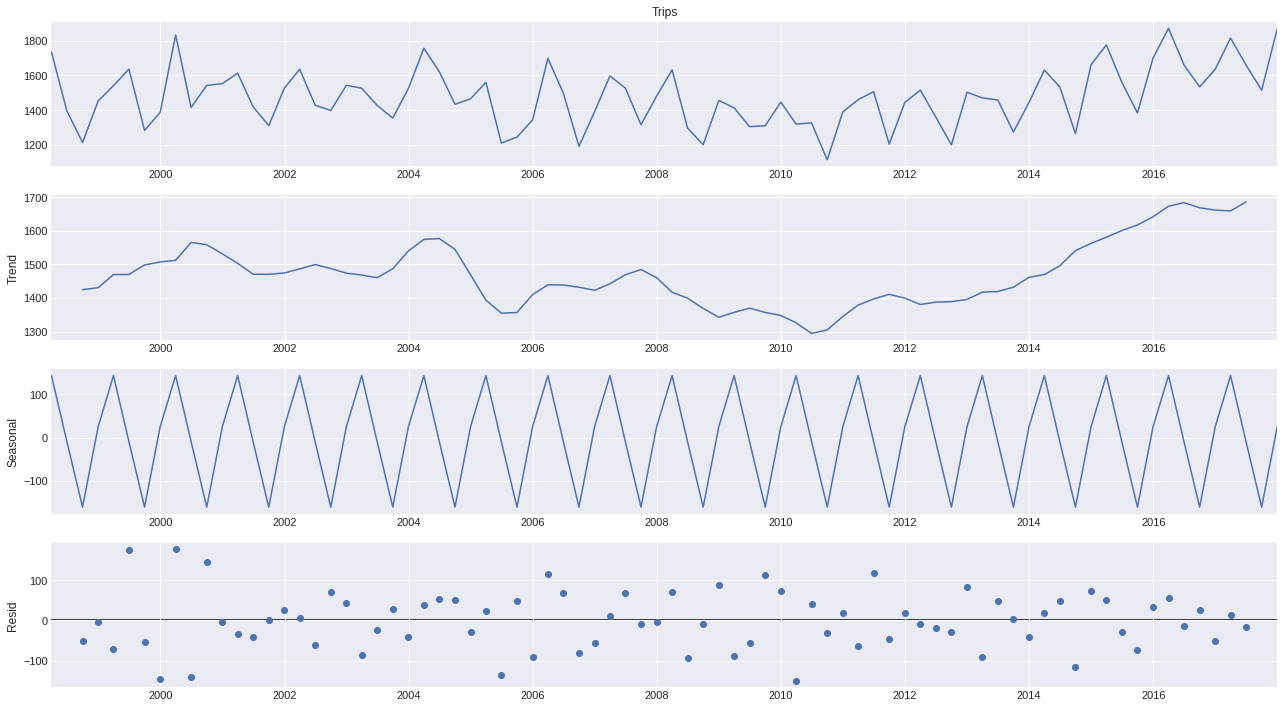

In [32]:
#Region: South Australia(trend-seasonality-noise)
from pylab import rcParams

rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(south_au, model='additive')#seasonal var. is constant
fig = decomposition.plot()

plt.show()

- The plot above clearly shows that the trips for state(South Australia) is unstable, along with its obvious seasonality.

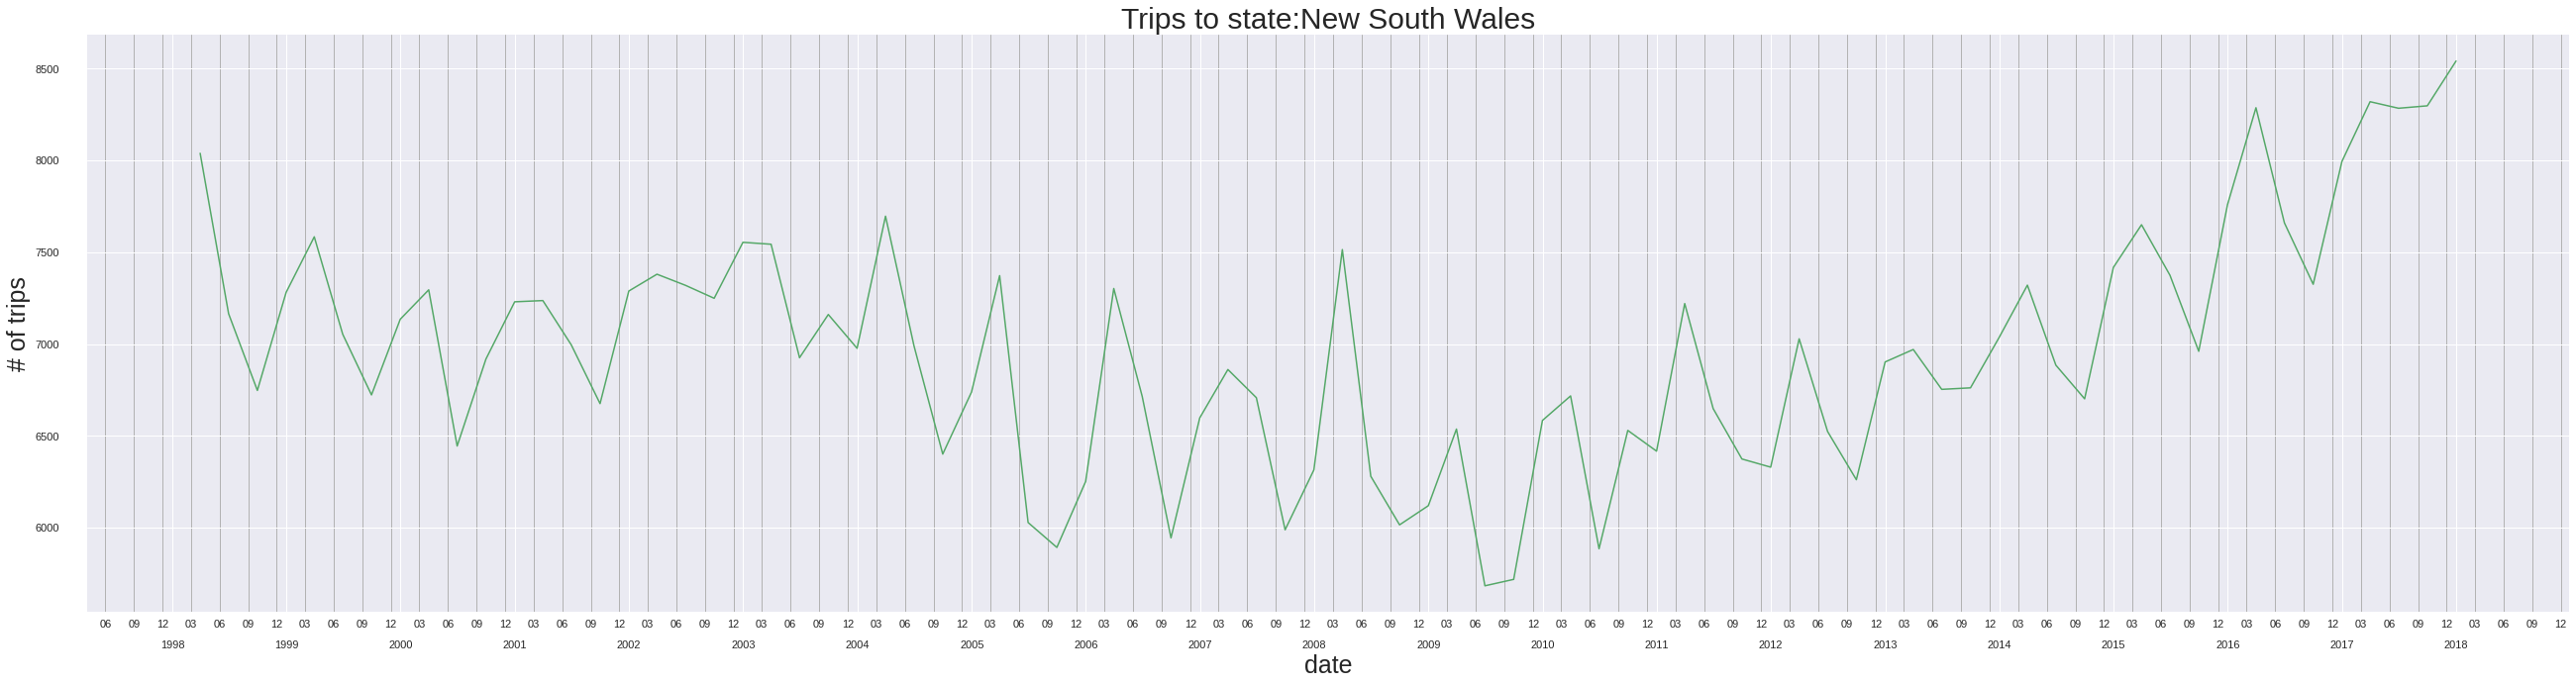

In [33]:
###### New South Wales ######
plt.style.use("seaborn-darkgrid")

plt.figure(figsize=(40, 10))
plt.title("Trips to state:New South Wales", fontsize=30)
plt.xlabel("date", fontsize=25)
plt.ylabel("# of trips", fontsize=25)

ax = plt.gca()

yearformatter = mdates.DateFormatter("%Y")
monthformatter = mdates.DateFormatter("%m")

yearlocator = mdates.YearLocator()
ax.xaxis.set_major_locator(yearlocator)

monthlocator = mdates.MonthLocator((3,6,9,12))
ax.xaxis.set_minor_locator(monthlocator)

ax.xaxis.set_major_formatter(yearformatter)
ax.xaxis.set_minor_formatter(monthformatter)

ax.tick_params(which='major', length=25)
ax.tick_params(which='minor',length=4 )

plt.grid(b=True, which='minor', color='0.7', linestyle='-')

plt.plot(df_state_nsw["date"], df_state_nsw["Trips"], color='g')


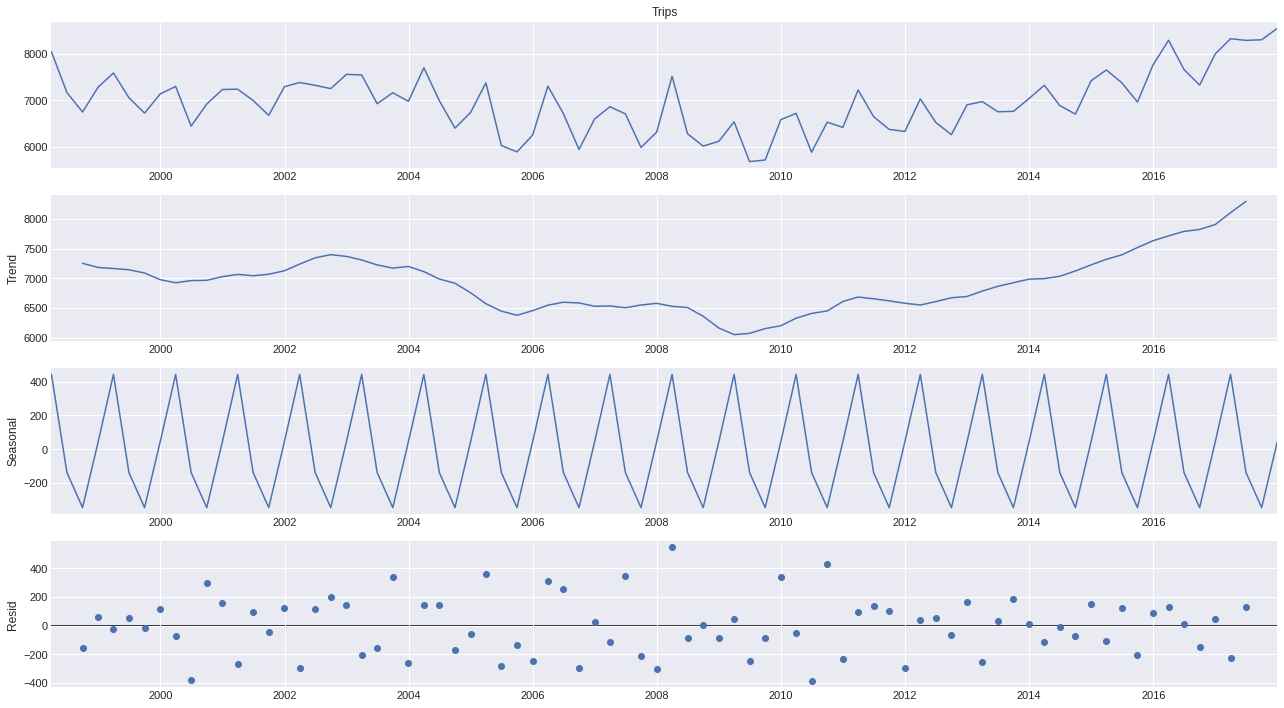

In [34]:
#Region: New South Wales(trend-seasonality-noise)
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(nsw, model='additive')
fig = decomposition.plot()
plt.show()

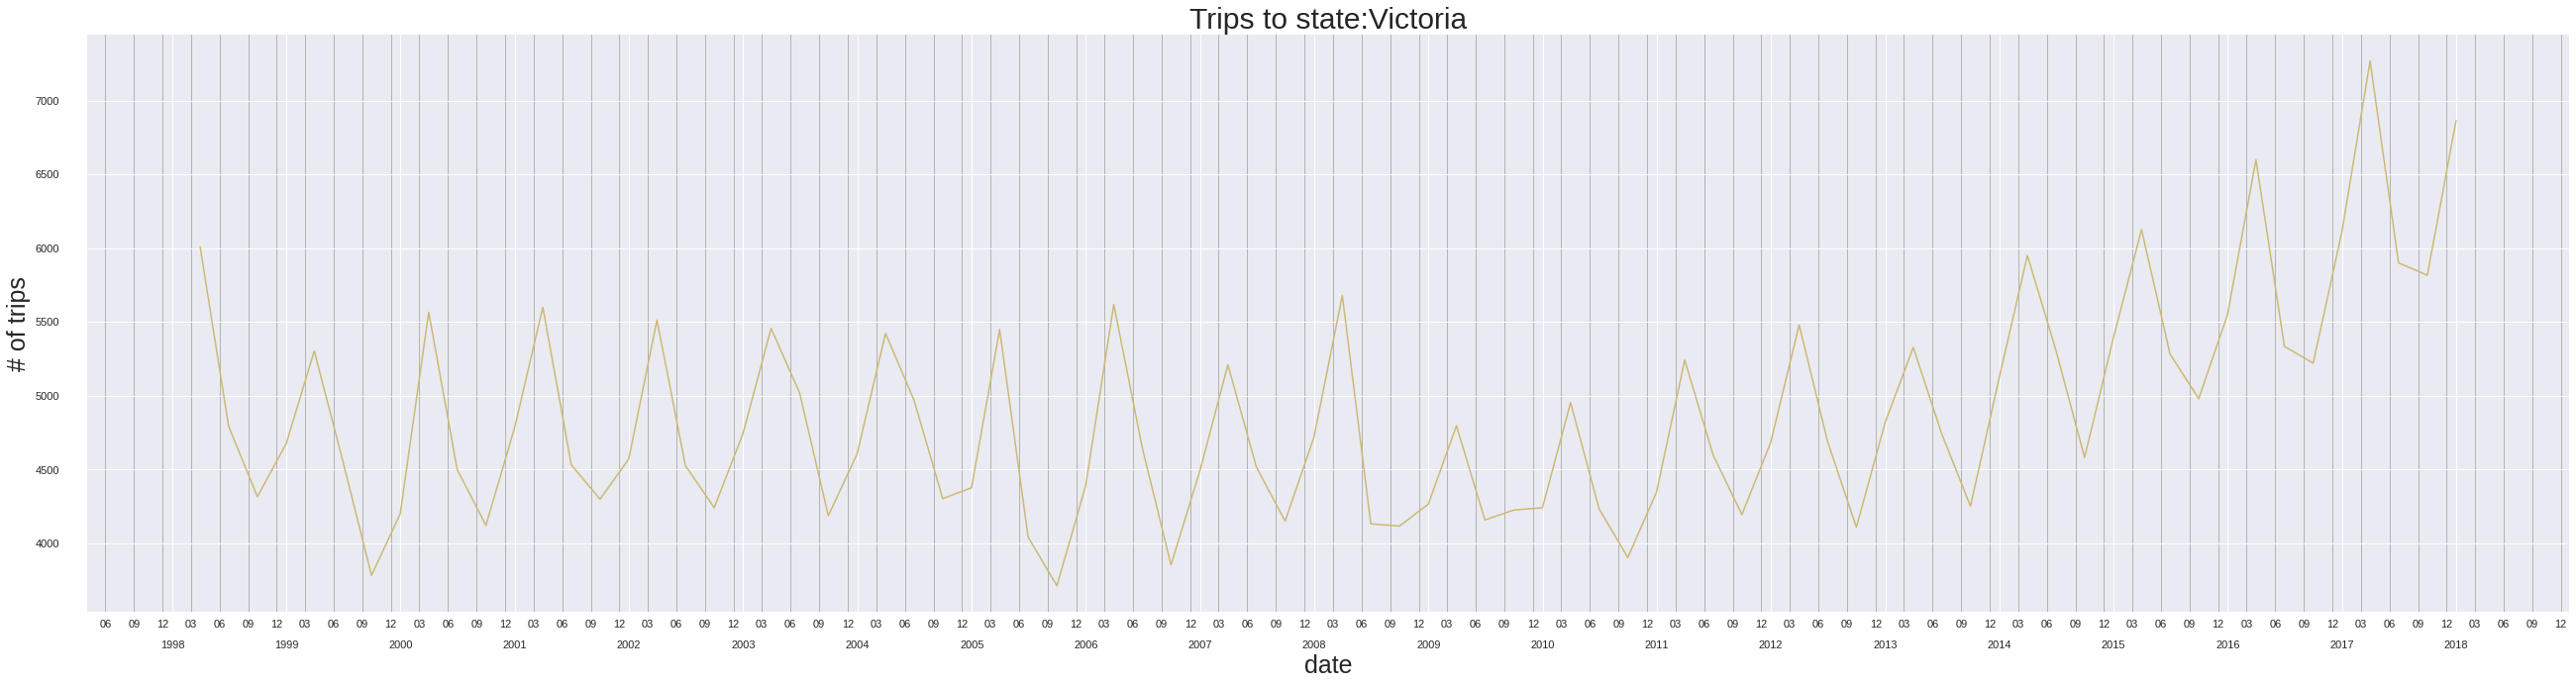

In [35]:
###### Victoria ######
plt.style.use("seaborn-darkgrid")

plt.figure(figsize=(40, 10))
plt.title("Trips to state:Victoria", fontsize=30)
plt.xlabel("date", fontsize=25)
plt.ylabel("# of trips", fontsize=25)

ax = plt.gca()

yearformatter = mdates.DateFormatter("%Y")
monthformatter = mdates.DateFormatter("%m")

yearlocator = mdates.YearLocator()
ax.xaxis.set_major_locator(yearlocator)

monthlocator = mdates.MonthLocator((3,6,9,12))
ax.xaxis.set_minor_locator(monthlocator)

ax.xaxis.set_major_formatter(yearformatter)
ax.xaxis.set_minor_formatter(monthformatter)

ax.tick_params(which='major', length=25)
ax.tick_params(which='minor',length=4 )

plt.grid(b=True, which='minor', color='0.7', linestyle='-')

plt.plot(df_state_vic["date"], df_state_vic["Trips"], color='y')


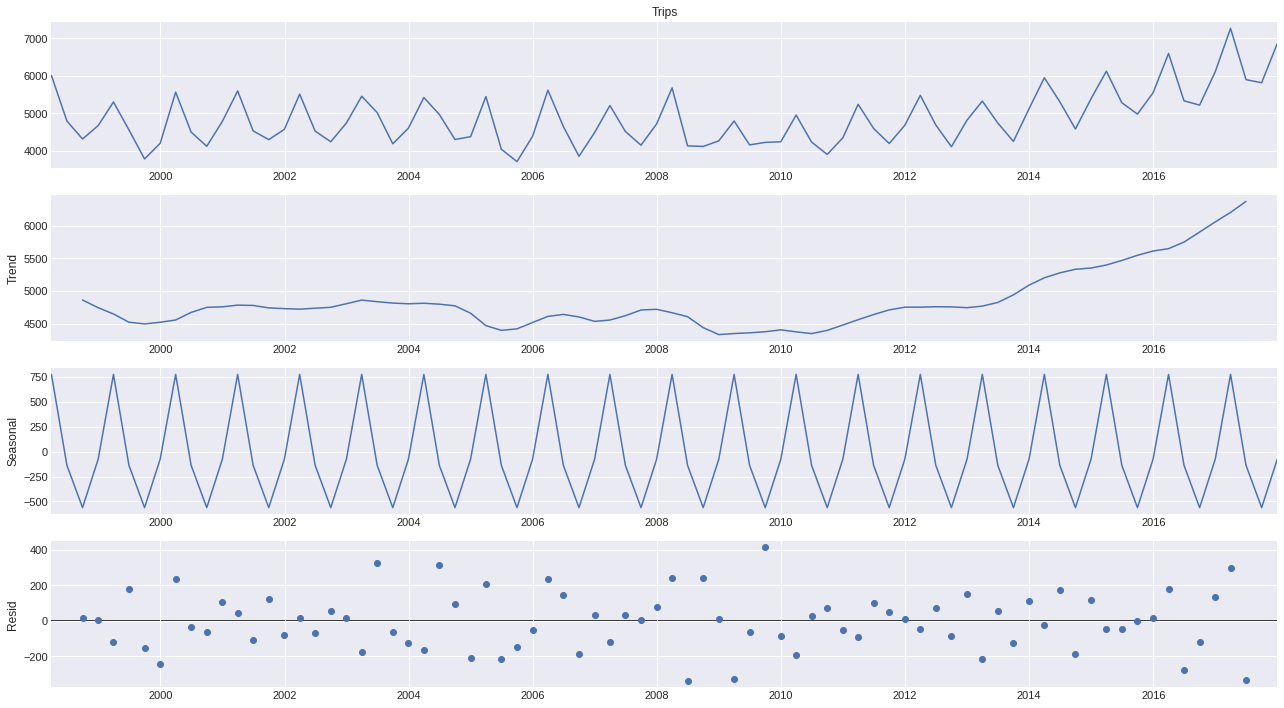

In [36]:
#Region: Victoria(trend-seasonality-noise)
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(vic, model='additive')
fig = decomposition.plot()
plt.show()

# Time Series of South Australia - New South Wales - Victoria

In [37]:
df_south_au = pd.DataFrame({'date':south_au.index, 'Trips':south_au.values})
df_nsw = pd.DataFrame({'date': nsw.index, 'Trips': nsw.values})
df_vic = pd.DataFrame({'date': vic.index, 'Trips': vic.values})

df_sa_nsw = df_south_au.merge(df_nsw, how='inner', on='date')
df_sa_nsw.rename(columns={'Trips_x': 'Trips_SA', 'Trips_y': 'Trips_NSW'}, inplace=True)

df_sa_nsw_vic = df_sa_nsw.merge(df_vic, how='inner', on='date')
df_sa_nsw_vic.rename(columns={'Trips': 'Trips_VIC'}, inplace=True)

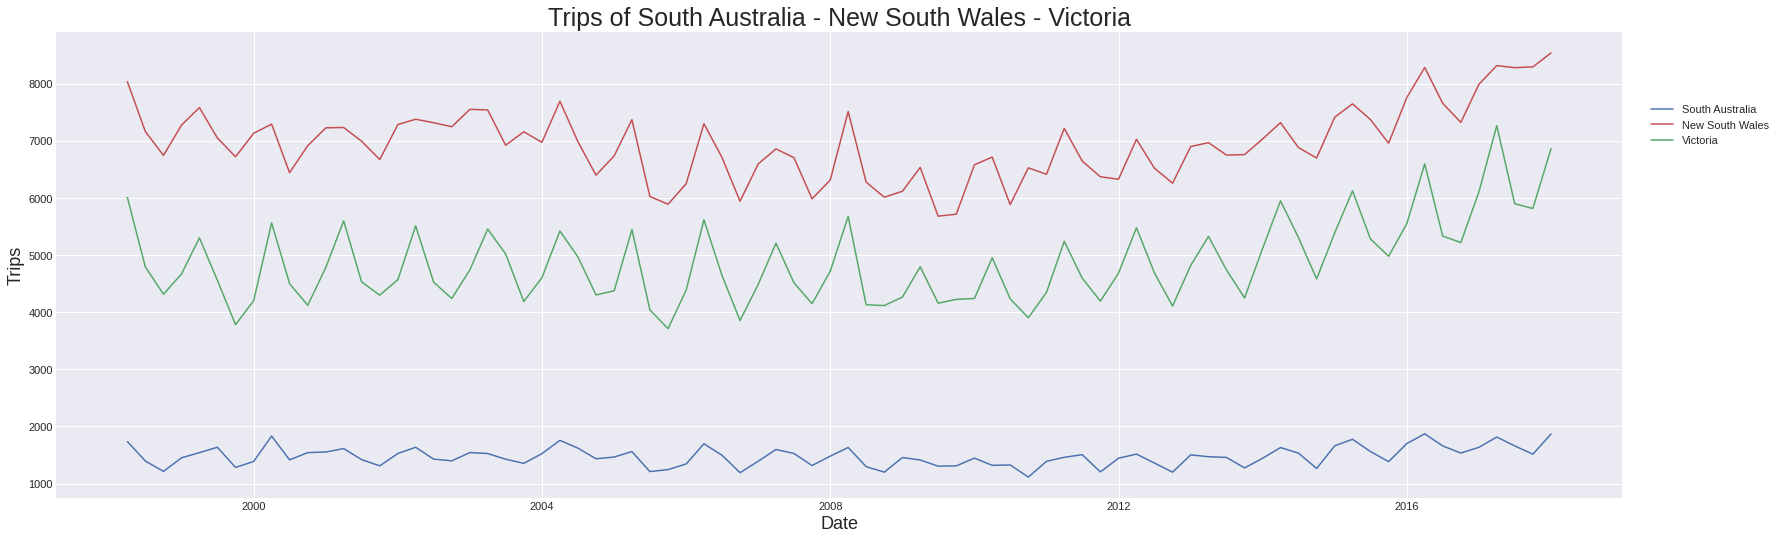

In [38]:
plt.figure(figsize=(25, 8))
plt.plot(df_sa_nsw_vic['date'], df_sa_nsw_vic['Trips_SA'], 'b-', label = 'South Australia')
plt.plot(df_sa_nsw_vic['date'], df_sa_nsw_vic['Trips_NSW'], 'r-', label = 'New South Wales')
plt.plot(df_sa_nsw_vic['date'], df_sa_nsw_vic['Trips_VIC'], 'g-', label = 'Victoria')
plt.xlabel('Date', fontsize=18); 
plt.ylabel('Trips', fontsize=18);
plt.title('Trips of South Australia - New South Wales - Victoria', fontsize=25)
plt.legend(loc="right", bbox_to_anchor=(1.10, 0.8));

- Before we can build a model, we must ensure that the time series is stationary. There are two primary way to determine whether a given time series is stationary.

==>Rolling Statistics: Plot the rolling mean and rolling standard deviation. The time series is stationary if they remain constant with time (with the naked eye look to see if the lines are straight and parallel to the x-axis).

==>Augmented Dickey-Fuller Test: The time series is considered stationary if the p-value is low (according to the null hypothesis) and the critical values at 1%, 5%, 10% confidence intervals are as close as possible to the ADF Statistics

In [39]:
df_stats_sa=df_south_au.set_index(["date"])
df_stats_sa.head(5)

,Trips
date,
1998-03-31,1735.438418
1998-06-30,1394.638319
1998-09-30,1213.330723
1998-12-31,1452.569969
1999-03-31,1541.181791


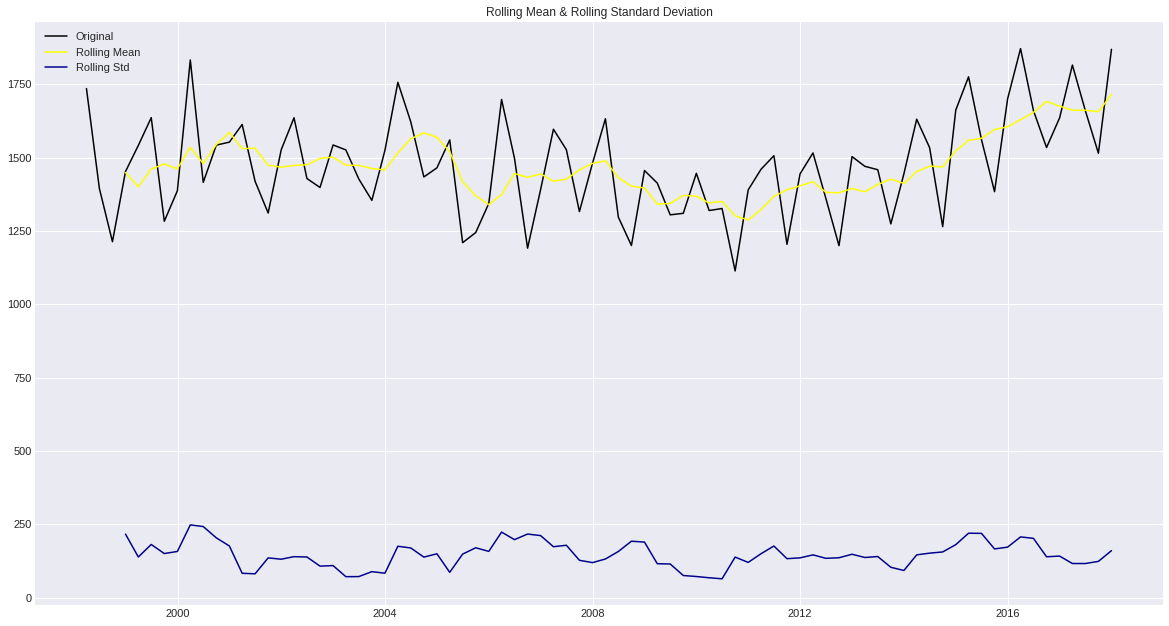

In [40]:
rolling_mean = df_stats_sa.rolling(window = 4).mean()
rolling_std = df_stats_sa.rolling(window = 4).std()

plt.plot(df_stats_sa, color = 'black', label = 'Original')
plt.plot(rolling_mean, color = 'yellow', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'darkblue', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

- As you can see, the rolling mean and rolling standard deviation is changing with time. Therefore, we can conclude that the time series is not stationary.

In [41]:
result = adfuller(df_stats_sa['Trips'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -0.11257973336283707
p-value: 0.9481710386783747
Critical Values:
	1%: -3.530398990560757
	5%: -2.9050874099328317
	10%: -2.5900010121107266


- The ADF Statistic is far from the critical values and the p-value is greater than the threshold (0.05). Thus, we can conclude that the time series is not stationary.

So, now what we will do?

==> There are multiple transformations that we can apply to a time series to render it stationary. For instance, we subtract the rolling mean.

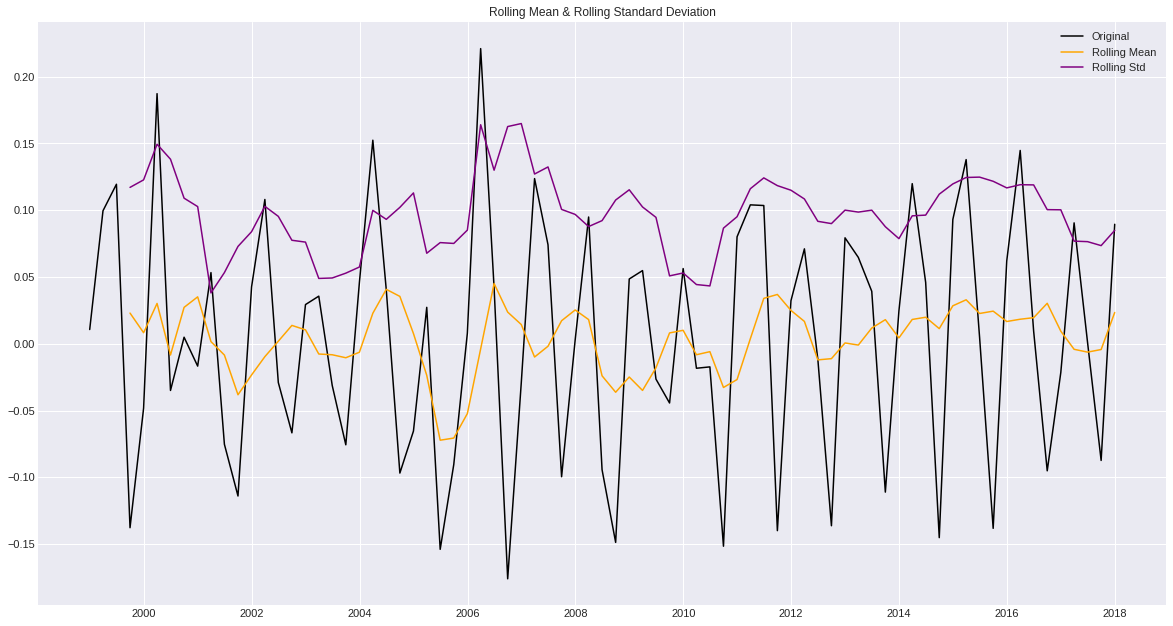

In [42]:
#Taking the log of the dep. var. to make lower the rate at which rol. mean increases
df_log = np.log(df_stats_sa)
#plt.plot(df_log)

rolling_mean_new = df_log.rolling(window=4).mean()
df_log_mean = df_log - rolling_mean_new
df_log_mean.dropna(inplace=True)

###### get stationarity ######
rol_mean = df_log_mean.rolling(window = 4).mean()
rol_std = df_log_mean.rolling(window = 4).std()

plt.plot(df_log_mean, color = 'black', label = 'Original')
plt.plot(rol_mean, color = 'orange', label = 'Rolling Mean')
plt.plot(rol_std, color = 'purple', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [43]:
result_new = adfuller(df_log_mean['Trips'])
print('ADF Statistic: {}'.format(result_new[0]))
print('p-value: {}'.format(result_new[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -2.8784089491783496
p-value: 0.04791696806233604
Critical Values:
	1%: -3.530398990560757
	5%: -2.9050874099328317
	10%: -2.5900010121107266


- As we can see, after subtracting the mean, the rolling mean and standard deviation are approximately horizontal. The p-value=0.04 is below the threshold of 0.05 and the ADF Statistic is close to the critical values. Now, we can say that the time series is stationary.



*Friends, I hope everyting is clear so far. Since you've came this far, you're wondering about the end of the movie, right? So, let's get a cup of coffee and stay with me:))☕️🍮*

One of the methods available in Python to model and predict future points of a Time Series is known as SARIMAX, which stands for Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors. Here, we will primarily focus on the ARIMA component, which is used to fit time-series data to better understand and forecast future points in the time series.

# Time series forecasting with ARIMA

#  **1. Parameter Selection for the ARIMA Time Series Model**

In [44]:
import itertools

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]
aic_min=np.inf
param_min=0
param_seasonal_min=0


#“grid search” to find the optimal set of parameters that yields the best performance for our model.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(south_au,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            aic_current=results.aic
            #print('ARIMA{}x{}4 - AIC:{}'.format(param, param_seasonal, aic_current))
            if(aic_current < aic_min):
                aic_min=aic_current
                param_min=param
                param_seasonal_min=param_seasonal
        except:
            continue
            
print(aic_min, "-->>", param_min,"---",param_seasonal_min)


741.6426203368939 -->> (1, 2, 2) --- (0, 2, 2, 4)


# **2. Fitting an ARIMA Time Series Model**

In [45]:
model = sm.tsa.statespace.SARIMAX(south_au,
                                order=param_min,
                                seasonal_order=param_seasonal_min,
                                enforce_stationarity=False,
                                enforce_invertibility=False)


results = model.fit()
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3064,0.204,1.499,0.134,-0.094,0.707
ma.L1,-2.0351,0.320,-6.359,0.000,-2.662,-1.408
ma.L2,1.0495,0.364,2.884,0.004,0.336,1.763
ma.S.L4,-2.1114,8.288,-0.255,0.799,-18.356,14.134
ma.S.L8,1.1171,9.378,0.119,0.905,-17.263,19.497
sigma2,6357.2508,5.23e+04,0.122,0.903,-9.61e+04,1.09e+05


- The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we’ll focus our attention on the table of coefficients. The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value nearly close to 0.05, so it is reasonable to retain all of them in our model.

- When fitting seasonal ARIMA models, it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

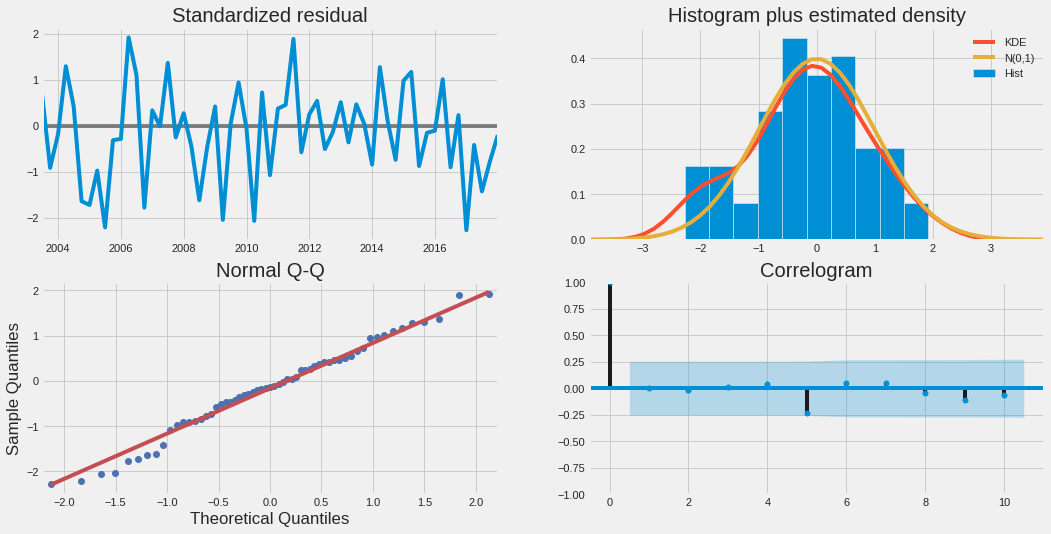

In [46]:
plt.style.use('fivethirtyeight')
results.plot_diagnostics(figsize=(16, 8))
plt.show()

- Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the  SARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

==> In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.


==> The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.


==> The residuals over time (top left plot) don’t display any obvious seasonality. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

# **3. Validating Forecasts(static/dynamic)**

- We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts.

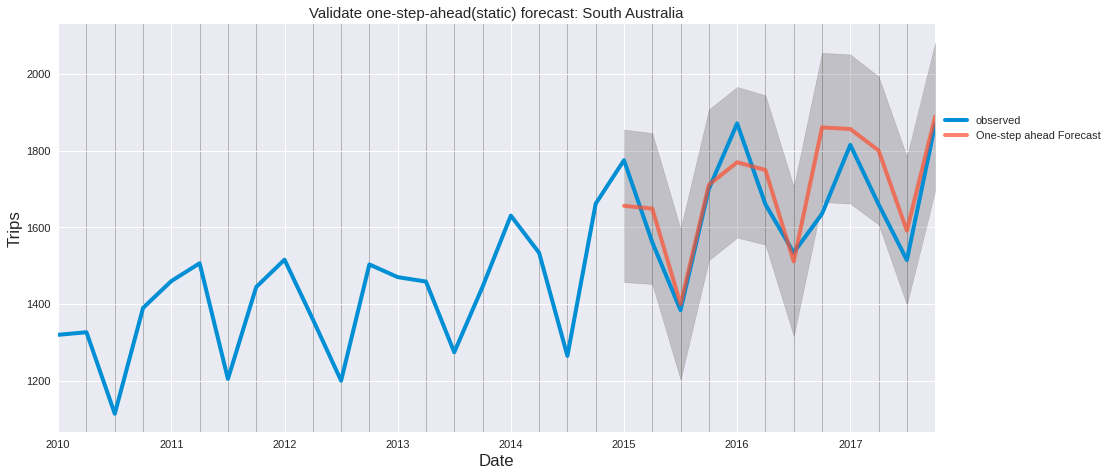

In [47]:
########## Static Forecasting(one-step ahead, dynamic=False) ##########

pred_static = results.get_prediction(start=pd.to_datetime('2015-03-31'), dynamic=False)
pred_ci_static = pred_static.conf_int()

plt.style.use("seaborn-darkgrid")
ax = south_au['2010':].plot(label='observed')

yearformatter = mdates.DateFormatter("%Y")
monthformatter = mdates.DateFormatter("%m")

yearlocator = mdates.YearLocator()
monthlocator = mdates.MonthLocator((3,6,9,12))

ax.xaxis.set_major_locator(yearlocator)
ax.xaxis.set_minor_locator(monthlocator)

ax.xaxis.set_major_formatter(yearformatter)
ax.xaxis.set_minor_formatter(monthformatter)

ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

pred_static.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci_static.index,
                pred_ci_static.iloc[:, 0],
                pred_ci_static.iloc[:, 1], color='k', alpha=.2)

plt.grid(b=True, which='minor', color='0.7', linestyle='-')

ax.set_xlabel('Date')
ax.set_ylabel('Trips')
plt.legend(loc='top', bbox_to_anchor=(1.2, .8))

plt.title("Validate one-step-ahead(static) forecast: South Australia", fontsize=15)

plt.show()


In [48]:
#the mean square error of static static forecast
y_forecasted = pred_static.predicted_mean
y_truth = south_au['2015-03-31':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The MSE of one-step-ahead(static) forecast: {}'.format(round(mse, 2)))

The MSE of one-step-ahead(static) forecast: 9978.6


- In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

==> better representation of our true predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

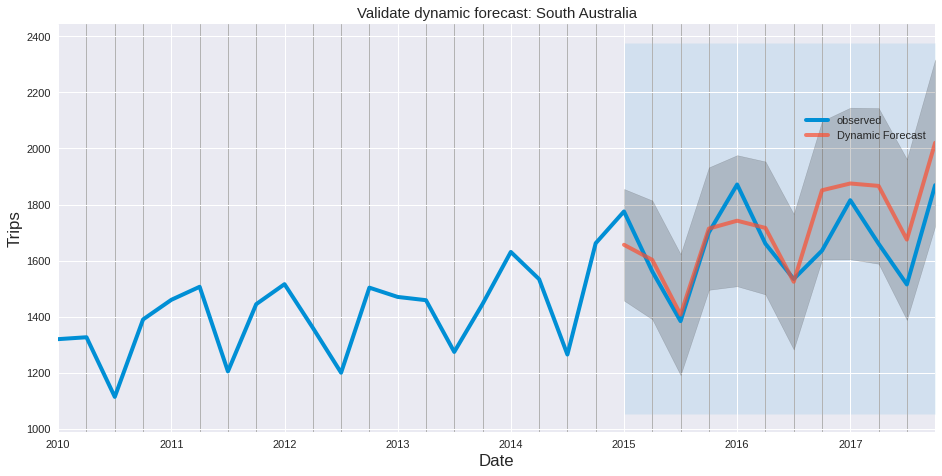

In [49]:
########## Dynamic Forecasting(dynamic=True) ##########

pred_dynamic = results.get_prediction(start=pd.to_datetime('2015-03-31'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()


plt.style.use("seaborn-darkgrid")
ax = south_au['2010':].plot(label='observed')

yearformatter = mdates.DateFormatter("%Y")
monthformatter = mdates.DateFormatter("%m")

yearlocator = mdates.YearLocator()
monthlocator = mdates.MonthLocator((3,6,9,12))

ax.xaxis.set_major_locator(yearlocator)
ax.xaxis.set_minor_locator(monthlocator)

ax.xaxis.set_major_formatter(yearformatter)
ax.xaxis.set_minor_formatter(monthformatter)

ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

plt.grid(b=True, which='minor', color='0.7', linestyle='-')

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-03-31'), south_au.index[-1],
                 alpha=.1, zorder=-1)


ax.set_xlabel('Date')
ax.set_ylabel('Trips')
plt.legend(loc='top', bbox_to_anchor=(1., .8))

plt.title("Validate dynamic forecast: South Australia", fontsize=15)

plt.show()

In [50]:
#the mean square error of static static forecast
y_forecasted_dynamic = pred_dynamic.predicted_mean
y_truth = south_au['2015-03-31':]
mse = ((y_forecasted_dynamic - y_truth) ** 2).mean()
print('The MSE of dynamic forecast: {}'.format(round(mse, 2)))

The MSE of dynamic forecast: 14800.5


MSE(one-step ahead forecast) < MSE(dynamic forecast) ==> its normal because we are relying on less historical data.

# 4.  Producing and visualizing forecasts for future

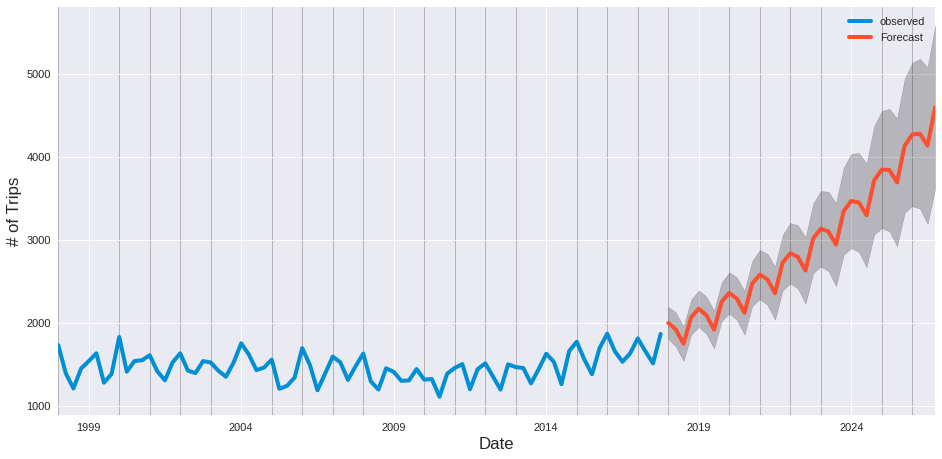

In [51]:

pred_uc = results.get_forecast(steps=36) #forecast next 12 years
pred_ci_uc = pred_uc.conf_int()

ax = south_au.plot(label='observed', figsize=(14, 7))
#ax = south_au['2010':].plot(label='observed')

yearformatter = mdates.DateFormatter("%Y")
monthformatter = mdates.DateFormatter("%m")

yearlocator = mdates.YearLocator()
monthlocator = mdates.MonthLocator((3,6,9,12))

ax.xaxis.set_major_locator(yearlocator)
ax.xaxis.set_minor_locator(monthlocator)

ax.xaxis.set_major_formatter(yearformatter)
ax.xaxis.set_minor_formatter(monthformatter)

ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)


plt.grid(b=True, which='minor', color='0.7', linestyle='-')

plt.title("", fontsize=15)

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci_uc.index,
                pred_ci_uc.iloc[:, 0],
                pred_ci_uc.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('# of Trips')
plt.legend()
plt.show()


- As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

# Time Series Forecasting with Prophet

<Figure size 1296x432 with 0 Axes>

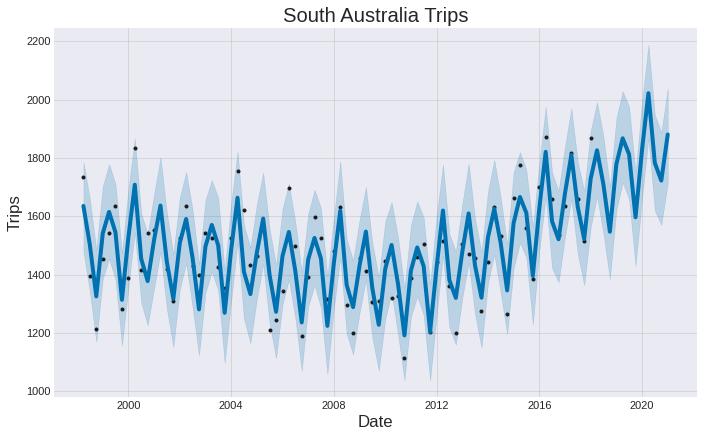

<Figure size 1296x432 with 0 Axes>

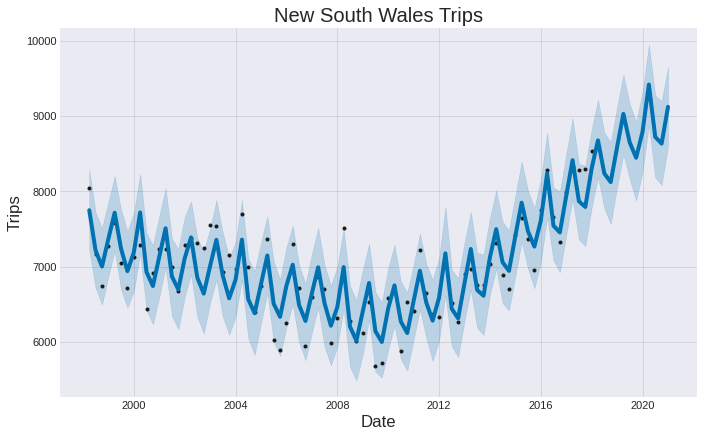

<Figure size 1296x432 with 0 Axes>

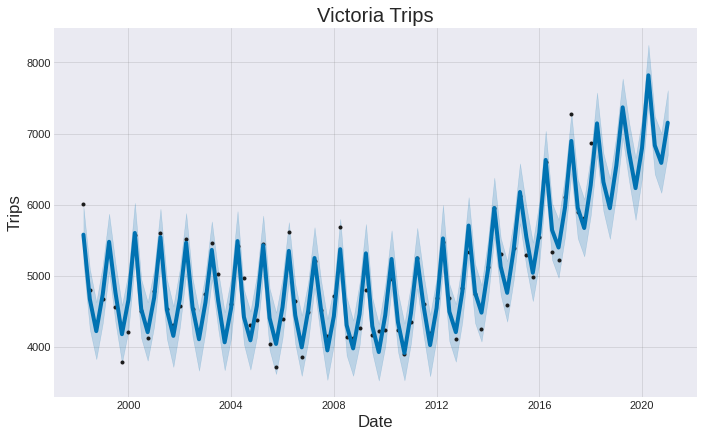

In [52]:
from fbprophet import Prophet

df_state_sa = df_state_sa.rename(columns={'date': 'ds', 'Trips': 'y'})
model_sa = Prophet(interval_width=0.95)
model_sa.fit(df_state_sa)

df_state_nsw = df_state_nsw.rename(columns={'date': 'ds', 'Trips': 'y'})
model_nsw = Prophet(interval_width=0.95)
model_nsw.fit(df_state_nsw)

df_state_vic = df_state_vic.rename(columns={'date': 'ds', 'Trips': 'y'})
model_vic = Prophet(interval_width=0.95)
model_vic.fit(df_state_vic)

######################### ###############################
sa_forecast = model_sa.make_future_dataframe(periods=12, freq='Q')
sa_forecast = model_sa.predict(sa_forecast)

nsw_forecast = model_nsw.make_future_dataframe(periods=12, freq='Q')
nsw_forecast = model_nsw.predict(nsw_forecast)

vic_forecast = model_vic.make_future_dataframe(periods=12, freq='Q')
vic_forecast = model_vic.predict(vic_forecast)

######################### ###############################
plt.figure(figsize=(18, 6))
model_sa.plot(sa_forecast, xlabel = 'Date', ylabel = 'Trips')
plt.title('South Australia Trips');

plt.figure(figsize=(18, 6))
model_nsw.plot(nsw_forecast, xlabel = 'Date', ylabel = 'Trips')
plt.title('New South Wales Trips');

plt.figure(figsize=(18, 6))
model_vic.plot(vic_forecast, xlabel = 'Date', ylabel = 'Trips')
plt.title('Victoria Trips');

==> Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series contribute to the overall forecasted values.

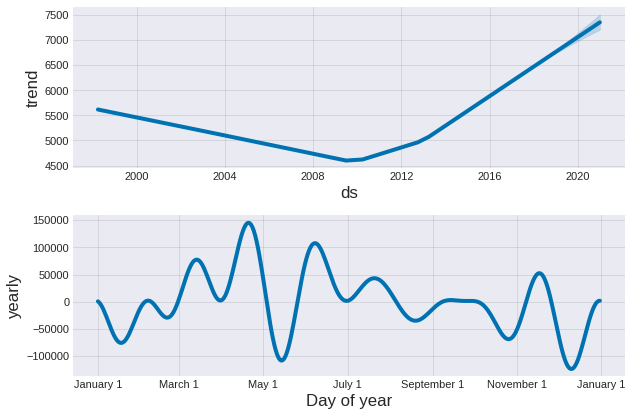

In [53]:
#model_sa.plot_components(sa_forecast);
model_nsw.plot_components(nsw_forecast);
#model_vic.plot_components(vic_forecast);

==> See each state trips have been linearly increasing over time. Also NSW and VIC states nearly have the same trends, although SA  has growth slightly slower than others. 
- State: SA --> worst month: May&Sep, best month: Jun&Aug
- State: NSW --> worst month: Dec, best month: Apr
- State: VIC --> worst month: Feb , best month: Jun

# Compare Forecasts of States(SA-NSW-VIC)

- We already have the forecasts for three years(2018-2020) for these three states into the future. We will now join them together to compare their future forecasts.

In [54]:
sa_names = ['SA_%s' % column for column in sa_forecast.columns]
nsw_names = ['NSW_%s' % column for column in nsw_forecast.columns]
vic_names = ['VIC_%s' % column for column in vic_forecast.columns]


sa_forecast_copy = sa_forecast.copy()
nsw_forecast_copy = nsw_forecast.copy()
vic_forecast_copy = vic_forecast.copy()

sa_forecast_copy.columns = sa_names
nsw_forecast_copy.columns = nsw_names
vic_forecast_copy.columns = vic_names

sa_nsw_forecast = pd.merge(sa_forecast_copy, nsw_forecast_copy, how = 'inner', left_on = 'SA_ds', right_on = 'NSW_ds')
sa_nsw_forecast = sa_nsw_forecast.rename(columns={'SA_ds': 'DATE'}).drop('NSW_ds', axis=1)

forecast = pd.merge(vic_forecast_copy, sa_nsw_forecast, how = 'inner', left_on = 'VIC_ds', right_on = 'DATE')
forecast = forecast.drop('DATE', axis=1)
forecast = forecast.rename(columns={'VIC_ds': 'DATE'})
forecast.head()

,DATE,VIC_trend,VIC_yhat_lower,VIC_yhat_upper,VIC_trend_lower,VIC_trend_upper,VIC_additive_terms,VIC_additive_terms_lower,VIC_additive_terms_upper,VIC_yearly,...,NSW_additive_terms,NSW_additive_terms_lower,NSW_additive_terms_upper,NSW_yearly,NSW_yearly_lower,NSW_yearly_upper,NSW_multiplicative_terms,NSW_multiplicative_terms_lower,NSW_multiplicative_terms_upper,NSW_yhat
0,1998-03-31,1929.968315,5180.381978,5970.385288,1929.968315,1929.968315,3647.262249,3647.262249,3647.262249,3647.262249,...,2132.937905,2132.937905,2132.937905,2132.937905,2132.937905,2132.937905,0.0,0.0,0.0,7750.826778
1,1998-06-30,1922.864663,4247.641458,5094.550483,1922.864663,1922.864663,2748.082815,2748.082815,2748.082815,2748.082815,...,1620.166370,1620.166370,1620.166370,1620.166370,1620.166370,1620.166370,0.0,0.0,0.0,7215.650765
2,1998-09-30,1915.682949,3826.545463,4628.147920,1915.682949,1915.682949,2304.494766,2304.494766,2304.494766,2304.494766,...,1431.230480,1431.230480,1431.230480,1431.230480,1431.230480,1431.230480,0.0,0.0,0.0,7004.064194
3,1998-12-31,1908.501235,4333.397332,5149.837923,1908.501235,1908.501235,2830.044052,2830.044052,2830.044052,2830.044052,...,1822.766618,1822.766618,1822.766618,1822.766618,1822.766618,1822.766618,0.0,0.0,0.0,7372.949650
4,1999-03-31,1901.475645,5058.726814,5871.890319,1901.475645,1901.475645,3575.289860,3575.289860,3575.289860,3575.289860,...,2190.291765,2190.291765,2190.291765,2190.291765,2190.291765,2190.291765,0.0,0.0,0.0,7718.316521


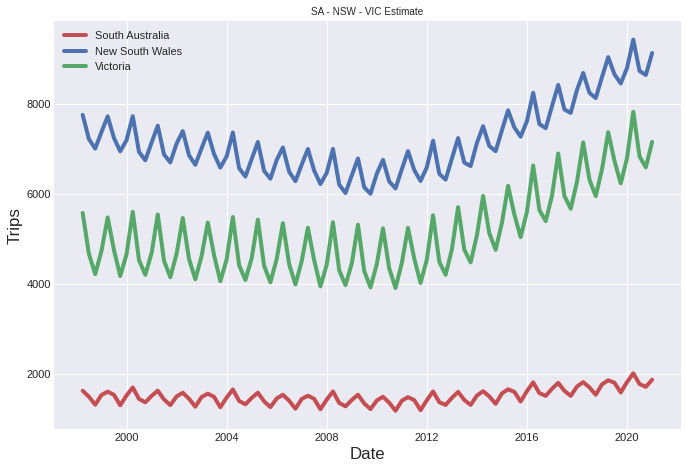

In [55]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['DATE'], forecast['SA_yhat'], 'r-', label="South Australia")
plt.plot(forecast['DATE'], forecast['NSW_yhat'], 'b-', label="New South Wales")
plt.plot(forecast['DATE'], forecast['VIC_yhat'], 'g-', label="Victoria")

plt.legend(); 
plt.xlabel('Date'); 
plt.ylabel('Trips')
plt.title('SA - NSW - VIC Estimate', fontsize=10);

# One-step-ahead in-sample evaluation with Prophet

In [56]:
pred_df=forecast[["DATE", "SA_yhat"]].set_index("DATE")
pred=pred_df['2015-03-31': '2017-12-31']["SA_yhat"]

y_truth = south_au['2015-03-31':]
mse = ((pred - y_truth) ** 2).mean()
print('The MSE in-sample static Prophet: {}'.format(round(mse, 2)))


The MSE in-sample static Prophet: 4267.47


- MSE(ARIMA)=10051.78, MSE(Prophet)=4267.47 ==> so Prophet performs better than ARIMA since Prophet considers non-linear relationship between elements of time series.

# LSTM out-of-sample prediction

This is not one-step-ahead, we first fit on train and then make predictions on test dataset.
For each prediction, use truth values, not forecasted values.



In [57]:
## Keras models
from tensorflow.keras import models, layers, preprocessing as kprocessing
from sklearn.preprocessing import MinMaxScaler

model_lstm = models.Sequential()
model_lstm.add(layers.LSTM(input_shape=(1,4), units=50, activation='relu', return_sequences=False) )
model_lstm.add(layers.Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_absolute_error')

In [58]:
scaler = MinMaxScaler(feature_range=(0,1))
sa_preprocessed = scaler.fit_transform(south_au.values.reshape(-1,1)).reshape(-1) 

In [59]:
## create X,y for train, since the data has seasnoality length=4(quarter-based)
ts_preprocessed = kprocessing.sequence.TimeseriesGenerator(data=sa_preprocessed, 
                                                           targets=sa_preprocessed, 
                                                           length=4, batch_size=1)
lst_X, lst_y = [], []
for i in range(len(ts_preprocessed)):
    xi, yi = ts_preprocessed[i] 
    lst_X.append(xi)
    lst_y.append(yi)
    
X = np.array(lst_X) #4'lü frameler
y = np.array(lst_y) #truth values

X_train=X[:-12, :] #son 3 yıl hariç
X_test=X[64:, :] #son 3 yıl

y_train=y[:-12, :]
y_test=y[64:, :]


model_lstm.fit(X_train, y_train, epochs=500, batch_size=4, verbose=2) 

pred_trips = model_lstm.predict(X_test) #0..1
pred_trip = scaler.inverse_transform(pred_trips) #100k, 80k etc 

Epoch 1/500
16/16 - 0s - loss: 0.3837
Epoch 2/500
16/16 - 0s - loss: 0.3058
Epoch 3/500
16/16 - 0s - loss: 0.2352
Epoch 4/500
16/16 - 0s - loss: 0.1714
Epoch 5/500
16/16 - 0s - loss: 0.1494
Epoch 6/500
16/16 - 0s - loss: 0.1456
Epoch 7/500
16/16 - 0s - loss: 0.1444
Epoch 8/500
16/16 - 0s - loss: 0.1416
Epoch 9/500
16/16 - 0s - loss: 0.1405
Epoch 10/500
16/16 - 0s - loss: 0.1385
Epoch 11/500
16/16 - 0s - loss: 0.1358
Epoch 12/500
16/16 - 0s - loss: 0.1333
Epoch 13/500
16/16 - 0s - loss: 0.1321
Epoch 14/500
16/16 - 0s - loss: 0.1288
Epoch 15/500
16/16 - 0s - loss: 0.1284
Epoch 16/500
16/16 - 0s - loss: 0.1271
Epoch 17/500
16/16 - 0s - loss: 0.1253
Epoch 18/500
16/16 - 0s - loss: 0.1263
Epoch 19/500
16/16 - 0s - loss: 0.1248
Epoch 20/500
16/16 - 0s - loss: 0.1246
Epoch 21/500
16/16 - 0s - loss: 0.1236
Epoch 22/500
16/16 - 0s - loss: 0.1238
Epoch 23/500
16/16 - 0s - loss: 0.1235
Epoch 24/500
16/16 - 0s - loss: 0.1228
Epoch 25/500
16/16 - 0s - loss: 0.1227
Epoch 26/500
16/16 - 0s - loss: 0.

In [60]:
y_truth = south_au['2015-03-31':].values
mse = ((pred_trip - y_truth) ** 2).mean()
print('The MSE for LSTM prediction: {}'.format(round(mse, 2)))


The MSE for LSTM prediction: 50162.09


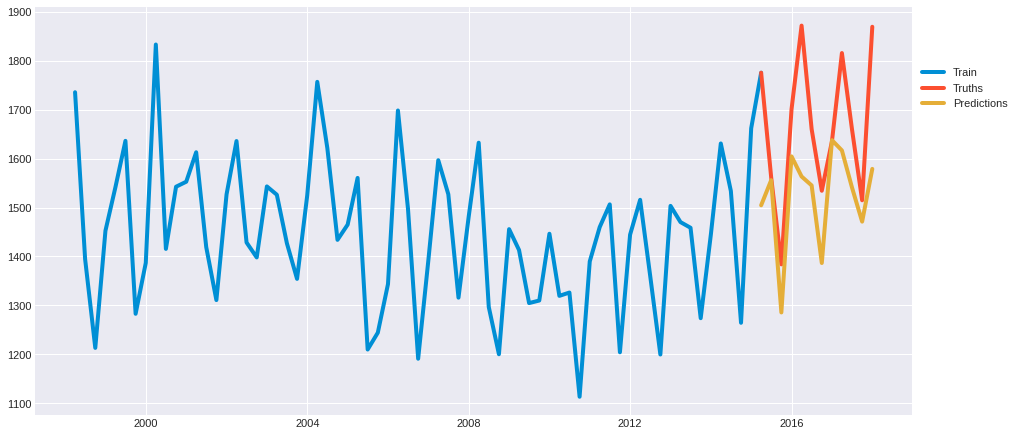

In [61]:
dd=south_au.copy()
dd["2015-03-31":]=pred_trip.ravel()#(12, 1) --> (12)
pred=dd["2015-03-31":]

#df=pd.DataFrame(zip(south_au["2015-03-31":], pred), columns=["truth", "pred"], index=pred.index)

plt.figure(figsize=(14,7))
plt.plot(south_au[:"2015-03-31"], label="Train")
plt.plot(south_au["2015-03-31":], label="Truths")
plt.plot(pred, label="Predictions")
plt.legend(loc="right", bbox_to_anchor=(1.12, 0.8));

# LSTM one-step-ahead forecast for future

In [62]:
model_lstm_2 = models.Sequential()
model_lstm_2.add(layers.LSTM(input_shape=(1,4), units=50, activation='relu', return_sequences=False) )
model_lstm_2.add(layers.Dense(1))
model_lstm_2.compile(optimizer='adam', loss='mean_absolute_error')

#here give full dataset to the lstm-model, then forecast for future!!
model_lstm_2.fit(X, y, epochs=500, batch_size=4, verbose=2) #batch_size=4(since 1 year=4 quarters)

Epoch 1/500
19/19 - 0s - loss: 0.4162
Epoch 2/500
19/19 - 0s - loss: 0.3217
Epoch 3/500
19/19 - 0s - loss: 0.2322
Epoch 4/500
19/19 - 0s - loss: 0.1731
Epoch 5/500
19/19 - 0s - loss: 0.1560
Epoch 6/500
19/19 - 0s - loss: 0.1545
Epoch 7/500
19/19 - 0s - loss: 0.1514
Epoch 8/500
19/19 - 0s - loss: 0.1504
Epoch 9/500
19/19 - 0s - loss: 0.1469
Epoch 10/500
19/19 - 0s - loss: 0.1465
Epoch 11/500
19/19 - 0s - loss: 0.1444
Epoch 12/500
19/19 - 0s - loss: 0.1420
Epoch 13/500
19/19 - 0s - loss: 0.1404
Epoch 14/500
19/19 - 0s - loss: 0.1384
Epoch 15/500
19/19 - 0s - loss: 0.1365
Epoch 16/500
19/19 - 0s - loss: 0.1349
Epoch 17/500
19/19 - 0s - loss: 0.1335
Epoch 18/500
19/19 - 0s - loss: 0.1326
Epoch 19/500
19/19 - 0s - loss: 0.1313
Epoch 20/500
19/19 - 0s - loss: 0.1317
Epoch 21/500
19/19 - 0s - loss: 0.1294
Epoch 22/500
19/19 - 0s - loss: 0.1287
Epoch 23/500
19/19 - 0s - loss: 0.1279
Epoch 24/500
19/19 - 0s - loss: 0.1260
Epoch 25/500
19/19 - 0s - loss: 0.1247
Epoch 26/500
19/19 - 0s - loss: 0.

In [63]:
## predict, append, re-predict
pred_list = []
init_list=list(y[-4:])#select last 4 truth(y) values for our next pred

for i in range(12):
    input_x = np.array(init_list[len(init_list) - 4 : ]) #take last 4 elements in "init_list" list
    input_x = np.reshape(input_x, (1, 1, input_x.shape[0])).astype(np.float32) # (4, 1) -->> (1, 1, 4) (since Keras wants this(1: sample))
    pred = model_lstm_2.predict(input_x)
    init_list.append(pred)
    pred_final = scaler.inverse_transform(pred)[0][0]
    pred_list.append(pred_final)


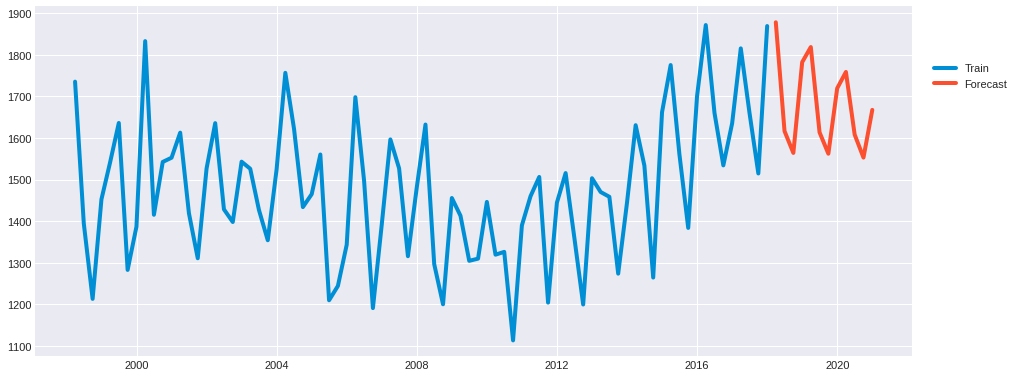

In [64]:
#convert pred to time-series
date_index=sa_forecast_copy["SA_ds"]
date_index=date_index[-12:] #future indexes(2018-2020)

df_pred=pd.DataFrame(pred_list, index=date_index, columns=["Forecasts"])

plt.figure(figsize=(14,6))
plt.plot(south_au, label="Train")
plt.plot(df_pred, label="Forecast")
plt.legend(loc="right", bbox_to_anchor=(1.12, 0.8));

References:

> https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

> https://medium.com/fintechexplained/understanding-auto-regressive-model-arima-4bd463b7a1bb

> https://medium.com/fintechexplained/forecasting-time-series-explained-5cc773b232b6

> https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3

> https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3#step-5

